### Isolation Forest for Time-Series Anomaly Detection
NYC Taxi Dataset

In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import moment, skew, kurtosis
from statsmodels.tsa.stattools import acf
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle 

#### Data preprocessing

In [3]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv")
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


Anomalies labeled according to the NAB github (https://github.com/numenta/NAB/blob/master/labels/):

In [4]:
data['anomaly'] = 0 # 1 = anomaly, 0 = normal

# Access the lists
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)
#Change according to ds: [0] = machine_temperature, [1] = twitter_volume , [2] = nyc_taxi
instances_of_anomaly_nyc_taxi = lists[2]        

# Marking the instances of anomaly in the dataset
for instance in instances_of_anomaly_nyc_taxi: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'anomaly'] = 1

Plot the data with anomalies marked

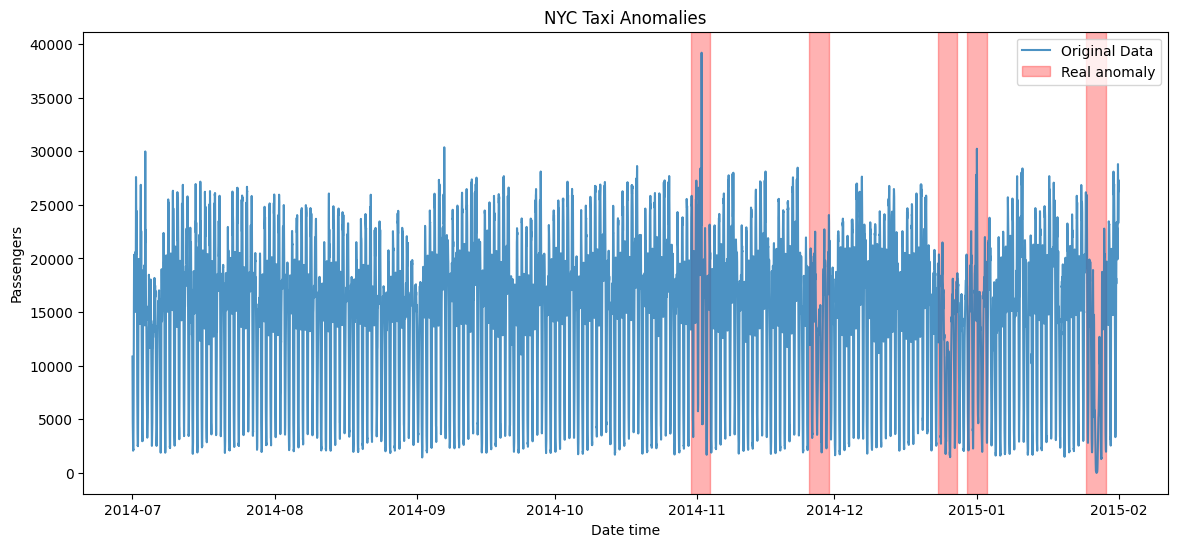

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], label='Original Data', alpha=0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
plt.title('NYC Taxi Anomalies')
plt.xlabel('Date time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

#### Split data into training, validation and testing sets
60% training, 20% validation and 20% testing

In [6]:
data_train = data[0:int(len(data)*0.6)]
data_val = data[int(len(data)*0.6):int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

labels_train = data_train['anomaly']
labels_val = data_val['anomaly']
labels_test = data_test['anomaly']

X_train = data_train.drop(['anomaly'], axis=1)
X_val = data_val.drop(['anomaly'], axis=1)
X_test = data_test.drop(['anomaly'], axis=1)

contamination_coef = sum(labels_train) / len(labels_train)

Normalize the data according to the training set

In [7]:
mean = X_train['value'].mean()
std = X_train['value'].std()
X_train['value'] = (X_train['value'] - mean) / std
X_val['value'] = (X_val['value'] - mean) / std
X_test['value'] = (X_test['value'] - mean) / std

#### Model

Extract features from time series data

In [8]:
def extract_features(time_series, window_size):
    features = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i:i+window_size]
        mean = np.mean(window)
        std_dev = np.std(window)
        skewness = moment(window, moment=3)
        kurtosis_val = moment(window, moment=4)
        autocorr_lag1 = acf(window, fft=False)[1]  # Autocorrelation at lag 1
        fourier_coeffs = np.abs(fft(window))[:window_size//2]  # Fourier transform coefficients (amplitudes) 
        
        feature_vector = [mean, std_dev, skewness, kurtosis_val , autocorr_lag1]
        feature_vector.extend(fourier_coeffs)
        
        features.append(feature_vector)
    
    return np.array(features)

In [9]:
window_size = 336
X_train_features = extract_features(np.array(X_train['value']), window_size)
X_val_features = extract_features(np.array(X_val['value']), window_size)
X_test_features = extract_features(np.array(X_test['value']), window_size)

In [10]:
(X_train_features.shape, X_val_features.shape, X_test_features.shape)

((5857, 173), (1729, 173), (1729, 173))

Train Isolation Forest model

Contamination parameter sets the proportion of anomalies expected in the data

In [11]:
model = IsolationForest(contamination=contamination_coef)
model.fit(X_train_features)

IsolationForest(contamination=0.03343023255813953)

In [12]:
# Predict anomaly scores
anomaly_scores = model.decision_function(X_val_features)

In [13]:
# Threshold for classifying instances as anomalies
# Bottom 1% of scores, since output of decision_function is between [-1, 1] with -1 being the most anomalous
threshold = np.percentile(anomaly_scores, 1)
print(threshold)

0.051878912002763865


In [14]:
# Compute the anomaly scores for the test set
test_scores = model.decision_function(X_test_features)

In [15]:
# Classify instances as normal (0) or anomalous (1)
val_predictions = np.where(anomaly_scores <= threshold, 1, 0)
test_predictions = np.where(test_scores <= threshold, 1, 0)

In [16]:
def assign_point_predictions(window_predictions, window_size):
    point_predictions = np.append(np.full((window_size-1)//2, window_predictions[0]), window_predictions)
    point_predictions = np.append(point_predictions, np.full((window_size-1)//2+1, window_predictions[-1]))
    return point_predictions

In [17]:
val_point_predictions = assign_point_predictions(val_predictions, window_size)
test_point_predictions = assign_point_predictions(test_predictions, window_size)

In [18]:
# Validation set output predictions
print("Predictions:", val_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_val, val_point_predictions)
conf_matrix = confusion_matrix(labels_val, val_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.8909883720930233
Confusion Matrix:
[[1839   18]
 [ 207    0]]


In [19]:
# Test set output predictions
print("Predictions:", test_predictions)

# Evaluate model performance
accuracy = accuracy_score(labels_test, test_point_predictions)
conf_matrix = confusion_matrix(labels_test, test_point_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Predictions: [1 1 0 ... 0 0 0]
Accuracy: 0.6332364341085271
Confusion Matrix:
[[1087  356]
 [ 401  220]]


In [20]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, test_point_predictions))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1443
           1       0.38      0.35      0.37       621

    accuracy                           0.63      2064
   macro avg       0.56      0.55      0.55      2064
weighted avg       0.63      0.63      0.63      2064



In [21]:
len(labels_test), len(test_point_predictions), len(test_predictions)

(2064, 2064, 1729)

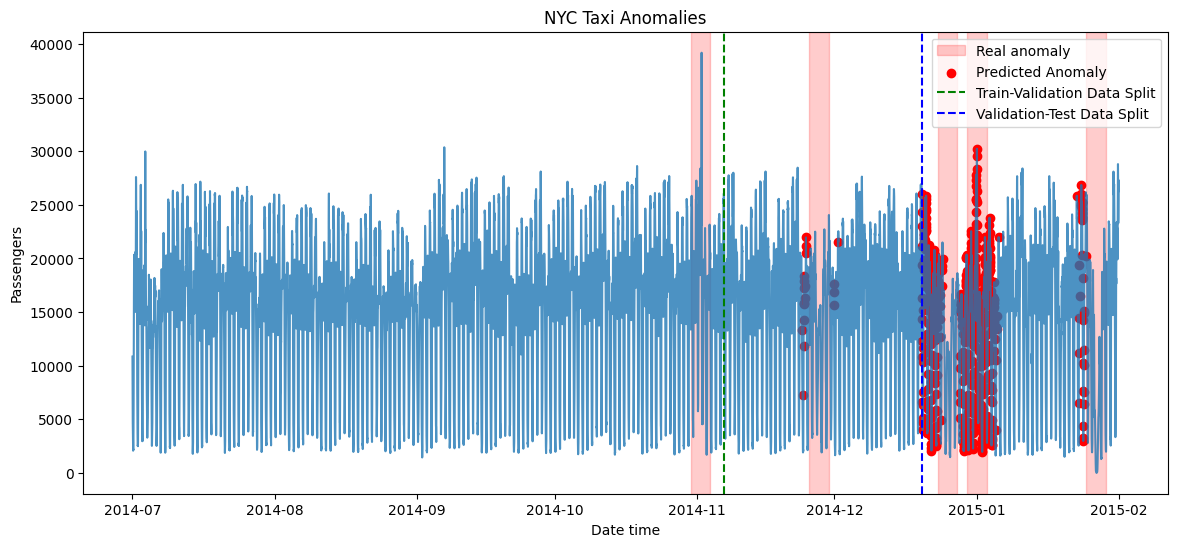

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['timestamp'], data['value'], alpha= 0.8)
ax.fill_between(data['timestamp'], 0, 1, where=data['anomaly'], color='red', alpha=0.2, transform=ax.get_xaxis_transform(),label='Real anomaly')
ax.scatter(data_val['timestamp'][val_point_predictions == 1], data_val['value'][val_point_predictions == 1], color='red', label='Predicted Anomaly')
ax.scatter(data_test['timestamp'][test_point_predictions == 1], data_test['value'][test_point_predictions == 1], color='red')
plt.title('NYC Taxi Anomalies')
plt.xlabel('Date time')
plt.ylabel('Passengers')
ax.axvline(data_val['timestamp'].iloc[0], color='green', linestyle='--', label='Train-Validation Data Split')
ax.axvline(data_val['timestamp'].iloc[-1], color='blue', linestyle='--', label='Validation-Test Data Split')
plt.legend()
plt.show()

In [23]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")) for start, end in instances_of_anomaly_nyc_taxi]
res = score_fn(data_test['timestamp'][test_point_predictions == 1], anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[-0.10999999998689224, -0.10999999998720657, -0.10999999998751334, -0.10999999998781278, -0.10999999998810502, -0.10999999998839026, -0.10999999998866865, -0.10999999998894038, -0.10999999998920558, -0.10999999998946443, -0.10999999998971706, -0.10999999998996365, -0.10999999999020432, -0.10999999999043922, -0.10999999999066848, -0.10999999999089224, -0.10999999999111064, -0.10999999999132382, -0.10999999999153186, -0.10999999999173493, -0.10999999999193312, -0.10999999999212656, -0.10999999999231537, -0.10999999999249964, -0.1099999999926795, -0.10999999999285504, -0.10999999999302637, -0.1099999999931936, -0.1099999999933568, -0.10999999999351612, -0.10999999999367159, -0.10999999999382334, -0.10999999999397146, -0.10999999999411601, -0.10999999999425712, -0.10999999999439483, -0.10999999999452924, -0.10999999999466042, -0.10999999999478847, -0.10999999999491344, -0.10999999999503542, -0.10999999999515446, -0.10999999999527066, -0.10999999999538405, -0.10999999999549476, -0.109999999